In this notebook, the only change is we use one-hot encoding for all the categorical features rather than integer mapping.

In [75]:
# Import the necessary packages.


from sklearn.datasets import load_iris

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from seaborn import set_style
set_style("whitegrid")

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import PrecisionRecallDisplay, precision_score, recall_score, f1_score

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder

In [76]:
# Load the data.
date = pd.read_csv("../Data/dim_date.csv")
claims = pd.read_csv("../Data/dim_claims.csv")
pa = pd.read_csv("../Data/dim_pa.csv")
bridge = pd.read_csv("../Data/bridge.csv")

In [77]:
# Join claims with bridge, in df dataframe.
df = claims.copy()
df = df.set_index('dim_claim_id').join(bridge.set_index('dim_claim_id'))


# Drop na.
pa_df = df.copy().dropna()
pa_df = pa_df.set_index('dim_date_id').join(date.set_index('dim_date_id'))

# Join the pa with rejected claims, in pa_df dataframe.
pa_df = pa_df.set_index('dim_pa_id').join(pa.set_index('dim_pa_id'))
pa_df.head()

,bin,drug,reject_code,pharmacy_claim_approved,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,correct_diagnosis,tried_and_failed,contraindication,pa_approved
dim_pa_id,,,,,,,,,,,,,,,,
1.0,417380,A,75.0,0,2017-01-01,2017,1,1,1,0,0,1,1,1,0,1
2.0,417740,A,76.0,0,2017-01-01,2017,1,1,1,0,0,1,1,0,0,1
3.0,417380,A,75.0,0,2017-01-01,2017,1,1,1,0,0,1,0,0,1,1
4.0,999001,A,76.0,0,2017-01-01,2017,1,1,1,0,0,1,1,1,0,1
5.0,417614,A,70.0,0,2017-01-01,2017,1,1,1,0,0,1,0,1,0,1


We use one-hot encoding instead of integers for encoding to see importance of each category.

In [78]:
# Get one hot encoding of bin column
one_hot = pd.get_dummies(pa_df['bin'])
# Drop bin column as it is now encoded
pa_df = pa_df.drop('bin',axis = 1)
# Join the encoded df
pa_df = pa_df.join(one_hot)

# Get one hot encoding of drug column
one_hot = pd.get_dummies(pa_df['drug'])
# Drop drug column as it is now encoded
pa_df = pa_df.drop('drug',axis = 1)
# Join the encoded df
pa_df = pa_df.join(one_hot)

# Get one hot encoding of reject_code column
one_hot = pd.get_dummies(pa_df['reject_code'])
# Drop reject_code column as it is now encoded
pa_df = pa_df.drop('reject_code',axis = 1)
# Join the encoded df
pa_df = pa_df.join(one_hot)

In [79]:
#For stratification, concatenate the features that will be used in the model

concat_features = ['correct_diagnosis', 'tried_and_failed', 'contraindication', 417380, 417614, 417740, 999001, 'A', 'B', 'C', 70.0, 75.0, 76.0]
# concat_features = ['tried_and_failed', 'contraindication', 417740, 'C', 70.0,'is_holiday']

pa_df['feature_id'] = ''

for feature in concat_features:
    pa_df['feature_id'] = pa_df['feature_id'] + pa_df[feature].astype(str)

pa_df['concat_all'] = pa_df['feature_id'] + pa_df['pa_approved'].astype(str)

In [80]:
pa_df.value_counts('concat_all')

concat_all
11001001001001    38461
10001001001001    28931
10010001000101    28214
11010001000101    28105
11001000100101    25254
                  ...  
11010001000100       23
00110000011001       23
00101000010011       19
01010000100010       13
01010001000100        7
Length: 192, dtype: int64

In [81]:
# Perform train-test split.
pa_train, pa_test = train_test_split( pa_df.copy(),
                                      test_size = .2,
                                      random_state = 123,
                                      shuffle = True,
                                      stratify = pa_df['concat_all'])

In [82]:
pa_tt, pa_val = train_test_split( pa_train.copy(),
                                      test_size = .2,
                                      random_state = 235,
                                      shuffle = True,
                                      stratify = pa_train['concat_all'])

In [ ]:


grid_cv = GridSearchCV(CatBoostClassifier(),
                          param_grid = {'iterations':range(5,16),
                                           'learning_rate':[1],
                                        'depth': range(1,17)},
                          scoring = 'f1',
                          cv = 2)

grid_cv.fit(pa_tt[features].values, pa_tt['pa_approved'])


0:	learn: 0.4699656	total: 17.8ms	remaining: 71.2ms
1:	learn: 0.4374272	total: 34.3ms	remaining: 51.4ms
2:	learn: 0.4244060	total: 50.3ms	remaining: 33.5ms
3:	learn: 0.4036885	total: 67.6ms	remaining: 16.9ms
4:	learn: 0.3923253	total: 87.9ms	remaining: 0us
0:	learn: 0.4710551	total: 18.4ms	remaining: 73.5ms
1:	learn: 0.4400810	total: 32ms	remaining: 48ms
2:	learn: 0.4257386	total: 47.7ms	remaining: 31.8ms
3:	learn: 0.4049395	total: 60.1ms	remaining: 15ms
4:	learn: 0.3934896	total: 73.1ms	remaining: 0us
0:	learn: 0.4699656	total: 14.9ms	remaining: 74.4ms
1:	learn: 0.4374272	total: 29.4ms	remaining: 58.7ms
2:	learn: 0.4244060	total: 44ms	remaining: 44ms
3:	learn: 0.4036885	total: 58.3ms	remaining: 29.1ms
4:	learn: 0.3923253	total: 72.8ms	remaining: 14.6ms
5:	learn: 0.3857232	total: 88.3ms	remaining: 0us
0:	learn: 0.4710551	total: 15.9ms	remaining: 79.4ms
1:	learn: 0.4400810	total: 25.8ms	remaining: 51.6ms
2:	learn: 0.4257386	total: 39ms	remaining: 39ms
3:	learn: 0.4049395	total: 53.8ms	r

0:	learn: 0.4699656	total: 19.4ms	remaining: 252ms
1:	learn: 0.4374272	total: 33.4ms	remaining: 200ms
2:	learn: 0.4244060	total: 51ms	remaining: 187ms
3:	learn: 0.4036885	total: 64.6ms	remaining: 161ms
4:	learn: 0.3923253	total: 77.8ms	remaining: 140ms
5:	learn: 0.3857232	total: 100ms	remaining: 133ms
6:	learn: 0.3800622	total: 117ms	remaining: 117ms
7:	learn: 0.3779231	total: 134ms	remaining: 100ms
8:	learn: 0.3765923	total: 149ms	remaining: 82.7ms
9:	learn: 0.3755426	total: 164ms	remaining: 65.6ms
10:	learn: 0.3744942	total: 179ms	remaining: 48.9ms
11:	learn: 0.3740957	total: 194ms	remaining: 32.4ms
12:	learn: 0.3729159	total: 210ms	remaining: 16.2ms
13:	learn: 0.3725844	total: 225ms	remaining: 0us
0:	learn: 0.4710551	total: 17.3ms	remaining: 225ms
1:	learn: 0.4400810	total: 28.4ms	remaining: 171ms
2:	learn: 0.4257386	total: 44.6ms	remaining: 163ms
3:	learn: 0.4049395	total: 65ms	remaining: 163ms
4:	learn: 0.3934896	total: 80.2ms	remaining: 144ms
5:	learn: 0.3874957	total: 103ms	rema

9:	learn: 0.3750627	total: 236ms	remaining: 23.6ms
10:	learn: 0.3746488	total: 259ms	remaining: 0us
0:	learn: 0.4438579	total: 18.7ms	remaining: 206ms
1:	learn: 0.4110604	total: 37.7ms	remaining: 189ms
2:	learn: 0.3901038	total: 57.4ms	remaining: 172ms
3:	learn: 0.3836499	total: 74.7ms	remaining: 149ms
4:	learn: 0.3788803	total: 95.8ms	remaining: 134ms
5:	learn: 0.3777060	total: 115ms	remaining: 115ms
6:	learn: 0.3766722	total: 136ms	remaining: 97ms
7:	learn: 0.3763169	total: 157ms	remaining: 78.4ms
8:	learn: 0.3749323	total: 175ms	remaining: 58.3ms
9:	learn: 0.3748308	total: 197ms	remaining: 39.4ms
10:	learn: 0.3740469	total: 215ms	remaining: 19.6ms
11:	learn: 0.3734044	total: 234ms	remaining: 0us
0:	learn: 0.4463235	total: 21.9ms	remaining: 241ms
1:	learn: 0.4127176	total: 43.2ms	remaining: 216ms
2:	learn: 0.3915371	total: 64.6ms	remaining: 194ms
3:	learn: 0.3851991	total: 86.8ms	remaining: 174ms
4:	learn: 0.3821042	total: 112ms	remaining: 156ms
5:	learn: 0.3784435	total: 138ms	remai

8:	learn: 0.3714797	total: 219ms	remaining: 0us
0:	learn: 0.4319577	total: 22.1ms	remaining: 177ms
1:	learn: 0.3908583	total: 41.2ms	remaining: 144ms
2:	learn: 0.3790089	total: 63ms	remaining: 126ms
3:	learn: 0.3767099	total: 109ms	remaining: 136ms
4:	learn: 0.3752806	total: 140ms	remaining: 112ms
5:	learn: 0.3746018	total: 166ms	remaining: 82.9ms
6:	learn: 0.3740579	total: 190ms	remaining: 54.2ms
7:	learn: 0.3736825	total: 217ms	remaining: 27.1ms
8:	learn: 0.3733493	total: 250ms	remaining: 0us
0:	learn: 0.4296296	total: 31.2ms	remaining: 280ms
1:	learn: 0.3892559	total: 58.2ms	remaining: 233ms
2:	learn: 0.3772557	total: 84.4ms	remaining: 197ms
3:	learn: 0.3748449	total: 106ms	remaining: 159ms
4:	learn: 0.3736146	total: 132ms	remaining: 132ms
5:	learn: 0.3728707	total: 163ms	remaining: 109ms
6:	learn: 0.3723363	total: 184ms	remaining: 79ms
7:	learn: 0.3719378	total: 204ms	remaining: 51ms
8:	learn: 0.3714797	total: 235ms	remaining: 26.1ms
9:	learn: 0.3711842	total: 262ms	remaining: 0us


0:	learn: 0.4216273	total: 26.2ms	remaining: 105ms
1:	learn: 0.3862088	total: 50.5ms	remaining: 75.7ms
2:	learn: 0.3783552	total: 73.3ms	remaining: 48.9ms
3:	learn: 0.3738539	total: 101ms	remaining: 25.4ms
4:	learn: 0.3733611	total: 131ms	remaining: 0us
0:	learn: 0.4194248	total: 21ms	remaining: 105ms
1:	learn: 0.3838979	total: 39.7ms	remaining: 79.5ms
2:	learn: 0.3771881	total: 90.2ms	remaining: 90.2ms
3:	learn: 0.3723832	total: 114ms	remaining: 57.2ms
4:	learn: 0.3718793	total: 135ms	remaining: 27.1ms
5:	learn: 0.3714052	total: 156ms	remaining: 0us
0:	learn: 0.4216273	total: 33.2ms	remaining: 166ms
1:	learn: 0.3862088	total: 59.2ms	remaining: 118ms
2:	learn: 0.3783552	total: 86.7ms	remaining: 86.7ms
3:	learn: 0.3738539	total: 122ms	remaining: 60.8ms
4:	learn: 0.3733611	total: 156ms	remaining: 31.1ms
5:	learn: 0.3731683	total: 184ms	remaining: 0us
0:	learn: 0.4194248	total: 28.5ms	remaining: 171ms
1:	learn: 0.3838979	total: 51.9ms	remaining: 130ms
2:	learn: 0.3771881	total: 81.2ms	rem

7:	learn: 0.3707367	total: 221ms	remaining: 166ms
8:	learn: 0.3706863	total: 255ms	remaining: 142ms
9:	learn: 0.3703208	total: 283ms	remaining: 113ms
10:	learn: 0.3702150	total: 308ms	remaining: 84.1ms
11:	learn: 0.3701343	total: 337ms	remaining: 56.2ms
12:	learn: 0.3701300	total: 371ms	remaining: 28.5ms
13:	learn: 0.3700976	total: 398ms	remaining: 0us
0:	learn: 0.4216273	total: 27.1ms	remaining: 353ms
1:	learn: 0.3862088	total: 52.8ms	remaining: 317ms
2:	learn: 0.3783552	total: 80.8ms	remaining: 296ms
3:	learn: 0.3738539	total: 106ms	remaining: 265ms
4:	learn: 0.3733611	total: 128ms	remaining: 231ms
5:	learn: 0.3731683	total: 150ms	remaining: 200ms
6:	learn: 0.3730544	total: 176ms	remaining: 176ms
7:	learn: 0.3729825	total: 204ms	remaining: 153ms
8:	learn: 0.3726791	total: 235ms	remaining: 130ms
9:	learn: 0.3726711	total: 264ms	remaining: 106ms
10:	learn: 0.3724231	total: 290ms	remaining: 79ms
11:	learn: 0.3722117	total: 315ms	remaining: 52.4ms
12:	learn: 0.3722050	total: 349ms	remain

0:	learn: 0.4124797	total: 41.6ms	remaining: 458ms
1:	learn: 0.3832164	total: 75.9ms	remaining: 380ms
2:	learn: 0.3733476	total: 112ms	remaining: 336ms
3:	learn: 0.3709665	total: 154ms	remaining: 307ms
4:	learn: 0.3707826	total: 184ms	remaining: 258ms
5:	learn: 0.3706616	total: 211ms	remaining: 211ms
6:	learn: 0.3706476	total: 234ms	remaining: 167ms
7:	learn: 0.3704986	total: 268ms	remaining: 134ms
8:	learn: 0.3702272	total: 302ms	remaining: 101ms
9:	learn: 0.3701398	total: 328ms	remaining: 65.7ms
10:	learn: 0.3701382	total: 348ms	remaining: 31.6ms
11:	learn: 0.3701395	total: 372ms	remaining: 0us
0:	learn: 0.4139762	total: 41.8ms	remaining: 460ms
1:	learn: 0.3851820	total: 82.3ms	remaining: 412ms
2:	learn: 0.3752475	total: 120ms	remaining: 361ms
3:	learn: 0.3734815	total: 163ms	remaining: 325ms
4:	learn: 0.3730206	total: 199ms	remaining: 279ms
5:	learn: 0.3728507	total: 223ms	remaining: 223ms
6:	learn: 0.3728128	total: 246ms	remaining: 176ms
7:	learn: 0.3724293	total: 289ms	remaining: 

7:	learn: 0.3700383	total: 283ms	remaining: 35.3ms
8:	learn: 0.3700390	total: 300ms	remaining: 0us
0:	learn: 0.4120492	total: 51.8ms	remaining: 415ms
1:	learn: 0.3822572	total: 95.4ms	remaining: 334ms
2:	learn: 0.3748102	total: 133ms	remaining: 266ms
3:	learn: 0.3735733	total: 172ms	remaining: 215ms
4:	learn: 0.3724351	total: 212ms	remaining: 169ms
5:	learn: 0.3724265	total: 234ms	remaining: 117ms
6:	learn: 0.3722177	total: 272ms	remaining: 77.6ms
7:	learn: 0.3719839	total: 311ms	remaining: 38.9ms
8:	learn: 0.3719775	total: 333ms	remaining: 0us
0:	learn: 0.4106844	total: 76.4ms	remaining: 688ms
1:	learn: 0.3802384	total: 123ms	remaining: 491ms
2:	learn: 0.3744610	total: 163ms	remaining: 380ms
3:	learn: 0.3716368	total: 207ms	remaining: 311ms
4:	learn: 0.3703935	total: 248ms	remaining: 248ms
5:	learn: 0.3703623	total: 272ms	remaining: 181ms
6:	learn: 0.3701699	total: 317ms	remaining: 136ms
7:	learn: 0.3700383	total: 361ms	remaining: 90.3ms
8:	learn: 0.3700390	total: 380ms	remaining: 42.

4:	learn: 0.3707206	total: 290ms	remaining: 0us
0:	learn: 0.4114260	total: 41.9ms	remaining: 168ms
1:	learn: 0.3815580	total: 93.2ms	remaining: 140ms
2:	learn: 0.3765107	total: 122ms	remaining: 81.5ms
3:	learn: 0.3737284	total: 162ms	remaining: 40.4ms
4:	learn: 0.3722647	total: 207ms	remaining: 0us
0:	learn: 0.4099246	total: 39ms	remaining: 195ms
1:	learn: 0.3796377	total: 74.4ms	remaining: 149ms
2:	learn: 0.3747256	total: 98.8ms	remaining: 98.8ms
3:	learn: 0.3715941	total: 132ms	remaining: 66.2ms
4:	learn: 0.3707206	total: 167ms	remaining: 33.4ms
5:	learn: 0.3705788	total: 191ms	remaining: 0us
0:	learn: 0.4114260	total: 41.1ms	remaining: 205ms
1:	learn: 0.3815580	total: 78.4ms	remaining: 157ms
2:	learn: 0.3765107	total: 106ms	remaining: 106ms
3:	learn: 0.3737284	total: 137ms	remaining: 68.3ms
4:	learn: 0.3722647	total: 183ms	remaining: 36.6ms
5:	learn: 0.3721366	total: 208ms	remaining: 0us
0:	learn: 0.4099246	total: 37.5ms	remaining: 225ms
1:	learn: 0.3796377	total: 70.6ms	remaining: 

In [84]:
grid_cv.best_params_

{'depth': 2, 'iterations': 12, 'learning_rate': 1}

In [85]:
grid_cv.best_score_

0.880250372459941

0:	learn: 0.4450840	total: 39.9ms	remaining: 239ms
1:	learn: 0.4118893	total: 76.6ms	remaining: 191ms
2:	learn: 0.3908261	total: 112ms	remaining: 149ms
3:	learn: 0.3846007	total: 147ms	remaining: 110ms
4:	learn: 0.3797908	total: 179ms	remaining: 71.6ms
5:	learn: 0.3783399	total: 212ms	remaining: 35.3ms
6:	learn: 0.3770586	total: 256ms	remaining: 0us
Validation Results:
Accuracy: 81.42%
Precision: 83.18%
Recall: 93.65%
f1: 88.10%
Train Results:
Accuracy: 81.42%
Precision: 83.18%
Recall: 93.65%
f1: 88.10%


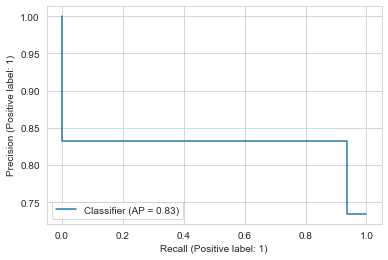

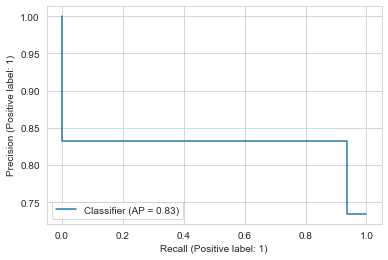

In [87]:
features = concat_features
# Model with best f1 score: 0.8810  (Precision: 0.8318, Recall: 0.9365)
model = CatBoostClassifier(iterations=7,
                           learning_rate=1,
                           depth=2)

model.fit(pa_tt[features].values, pa_tt['pa_approved'])

# make predictions for validation data
y_pred = model.predict(pa_val[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for validation data
accuracy = accuracy_score(pa_val['pa_approved'], predictions)
precision = precision_score(pa_val['pa_approved'], predictions)
recall = recall_score(pa_val['pa_approved'], predictions)
f1 = f1_score(pa_val['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_val['pa_approved'], predictions)

# make predictions for training data
y_pred = model.predict(pa_tt[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for training data
accuracy = accuracy_score(pa_tt['pa_approved'], predictions)
precision = precision_score(pa_tt['pa_approved'], predictions)
recall = recall_score(pa_tt['pa_approved'], predictions)
f1 = f1_score(pa_tt['pa_approved'], predictions)
print("Train Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_tt['pa_approved'], predictions)


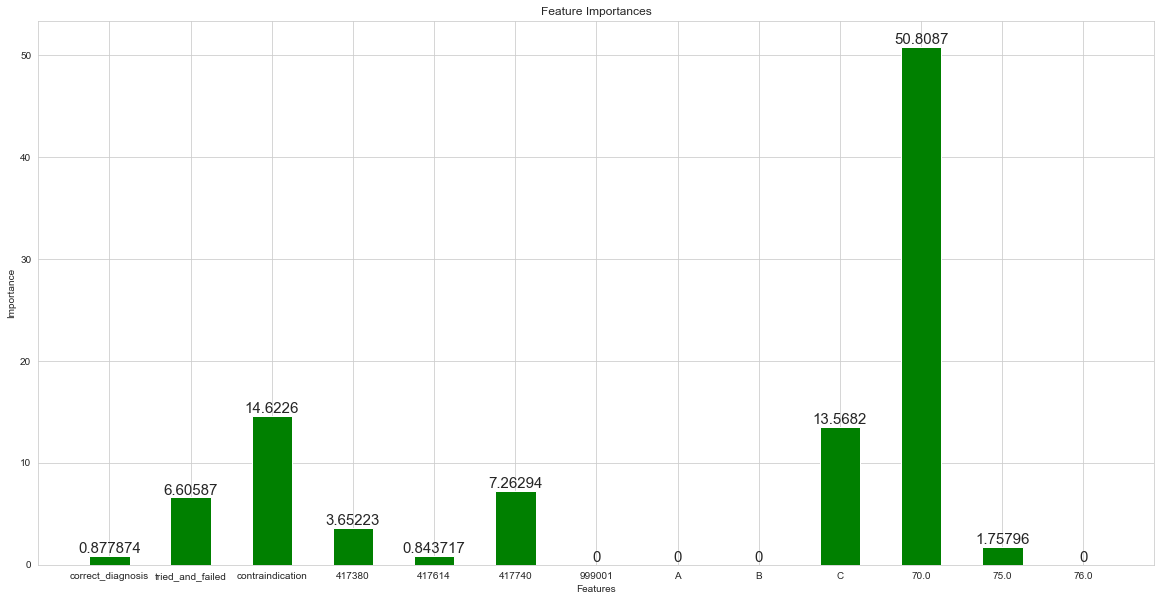

In [67]:
# Bar plot for the feature importances.


fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)
# creating the bar plot
#plt.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
#        width = 0.5)
ax.bar_label(bars, fontsize = 15)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

We'll train the model without zero-importance features.

0:	learn: 0.4450840	total: 29.6ms	remaining: 177ms
1:	learn: 0.4118893	total: 55.1ms	remaining: 138ms
2:	learn: 0.3908261	total: 82.5ms	remaining: 110ms
3:	learn: 0.3846007	total: 110ms	remaining: 82.2ms
4:	learn: 0.3809415	total: 139ms	remaining: 55.4ms
5:	learn: 0.3769148	total: 167ms	remaining: 27.8ms
6:	learn: 0.3758924	total: 194ms	remaining: 0us
Validation Results:
Accuracy: 81.40%
Precision: 84.04%
Recall: 92.17%
f1: 87.92%
Train Results:
Accuracy: 81.39%
Precision: 84.04%
Recall: 92.17%
f1: 87.92%


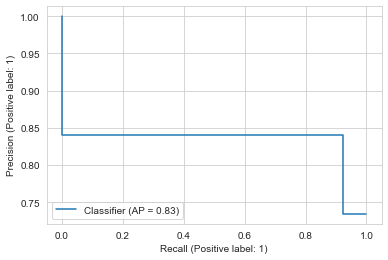

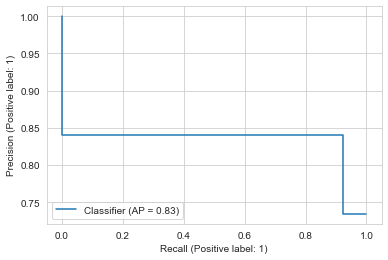

In [68]:
features = ['correct_diagnosis', 'tried_and_failed', 'contraindication', 417380, 417614, 417740,'C', 70.0, 75.0]

# Model with best f1 score: 0.8810  (Precision: 0.8318, Recall: 0.9365)
model = CatBoostClassifier(iterations=7,
                           learning_rate=1,
                           depth=2)

model.fit(pa_tt[features].values, pa_tt['pa_approved'])

# make predictions for validation data
y_pred = model.predict(pa_val[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for validation data
accuracy = accuracy_score(pa_val['pa_approved'], predictions)
precision = precision_score(pa_val['pa_approved'], predictions)
recall = recall_score(pa_val['pa_approved'], predictions)
f1 = f1_score(pa_val['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_val['pa_approved'], predictions)

# make predictions for training data
y_pred = model.predict(pa_tt[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for training data
accuracy = accuracy_score(pa_tt['pa_approved'], predictions)
precision = precision_score(pa_tt['pa_approved'], predictions)
recall = recall_score(pa_tt['pa_approved'], predictions)
f1 = f1_score(pa_tt['pa_approved'], predictions)
print("Train Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_tt['pa_approved'], predictions)


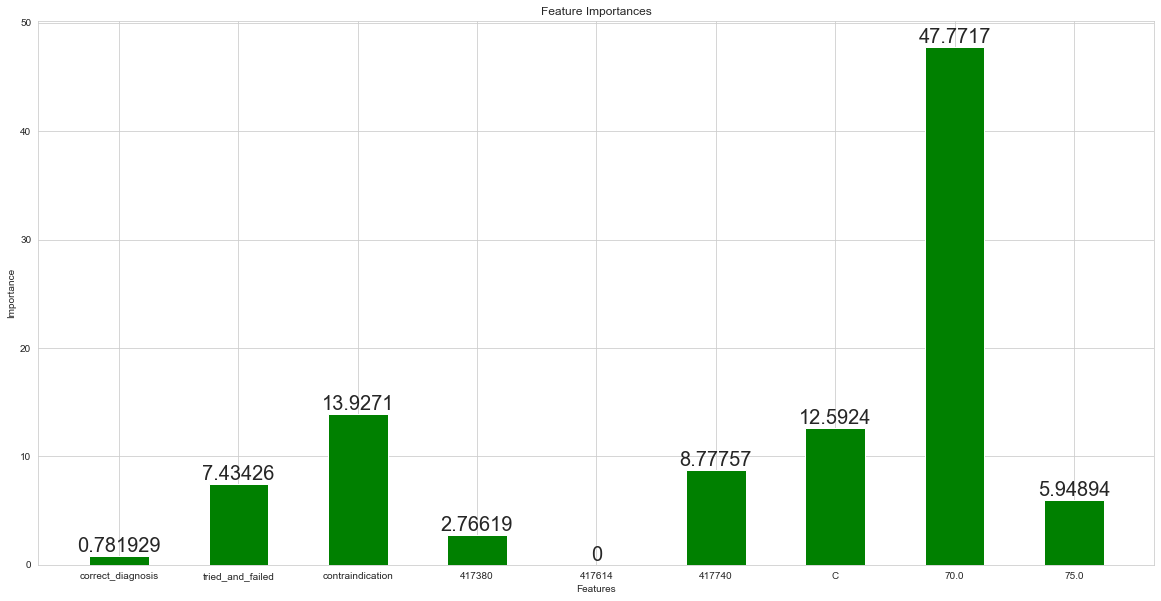

In [70]:
fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)
# creating the bar plot
#plt.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
#        width = 0.5)
ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

There is a slight change in the performance. We'll train the model without features features with importance less than 6.

0:	learn: 0.4450840	total: 29.7ms	remaining: 178ms
1:	learn: 0.4118893	total: 54.1ms	remaining: 135ms
2:	learn: 0.3908261	total: 82.2ms	remaining: 110ms
3:	learn: 0.3846007	total: 109ms	remaining: 81.7ms
4:	learn: 0.3793826	total: 135ms	remaining: 53.8ms
5:	learn: 0.3790109	total: 163ms	remaining: 27.2ms
6:	learn: 0.3781070	total: 190ms	remaining: 0us
Validation Results:
Accuracy: 81.29%
Precision: 83.24%
Recall: 93.31%
f1: 87.99%
Train Results:
Accuracy: 81.28%
Precision: 83.23%
Recall: 93.31%
f1: 87.98%


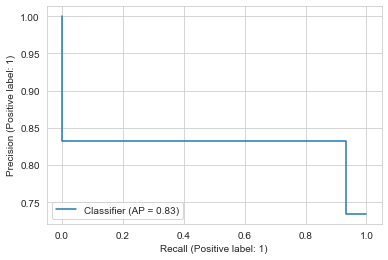

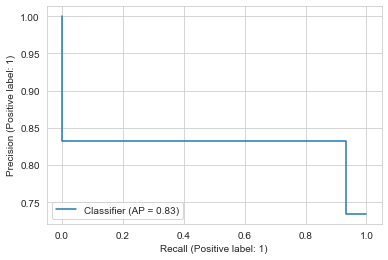

In [73]:
features = ['tried_and_failed', 'contraindication', 417740,'C', 70.0]

# Model with best f1 score: 0.8810  (Precision: 0.8318, Recall: 0.9365)
model = CatBoostClassifier(iterations=7,
                           learning_rate=1,
                           depth=2)

model.fit(pa_tt[features].values, pa_tt['pa_approved'])

# make predictions for validation data
y_pred = model.predict(pa_val[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for validation data
accuracy = accuracy_score(pa_val['pa_approved'], predictions)
precision = precision_score(pa_val['pa_approved'], predictions)
recall = recall_score(pa_val['pa_approved'], predictions)
f1 = f1_score(pa_val['pa_approved'], predictions)
print("Validation Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_val['pa_approved'], predictions)

# make predictions for training data
y_pred = model.predict(pa_tt[features].values)
predictions = [round(value) for value in y_pred]

# evaluate predictions for training data
accuracy = accuracy_score(pa_tt['pa_approved'], predictions)
precision = precision_score(pa_tt['pa_approved'], predictions)
recall = recall_score(pa_tt['pa_approved'], predictions)
f1 = f1_score(pa_tt['pa_approved'], predictions)
print("Train Results:")
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print("Precision: %.2f%%" % (precision * 100.0))
print("Recall: %.2f%%" % (recall * 100.0))
print("f1: %.2f%%" % (f1 * 100.0))
display = PrecisionRecallDisplay.from_predictions(pa_tt['pa_approved'], predictions)

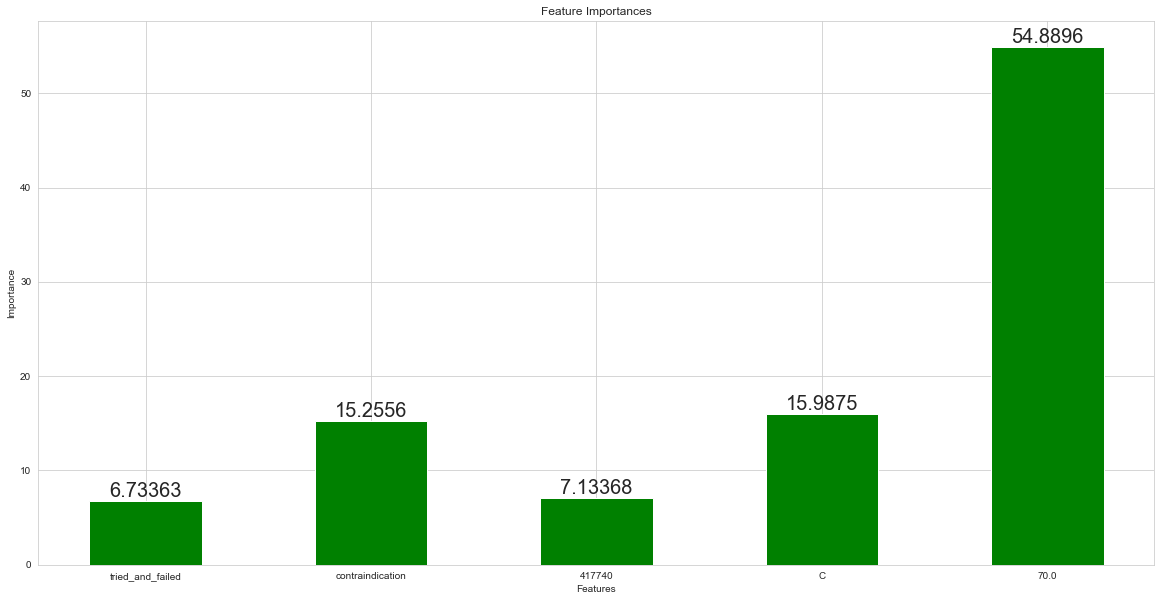

In [74]:
fig, ax = plt.subplots(figsize=(20,10))
bars = ax.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
        width = 0.5)
# creating the bar plot
#plt.bar(np.array(features).astype(str), model.feature_importances_, color ='green',
#        width = 0.5)
ax.bar_label(bars, fontsize = 20)
plt.xlabel("Features")
plt.ylabel("Importance")
plt.title("Feature Importances")
plt.show()

This is a simpler model with almost the same performance.